In [12]:
import geopandas as gpd
from shapely.geometry import Point

# Load data
parcels = gpd.read_file('cambridge_parcels.geojson')

# Define Harvard Square location (fixed coordinates)
harvard_square = Point(-71.1189, 42.3736)

# Create GeoDataFrame for Harvard Square
harvard_gdf = gpd.GeoDataFrame(geometry=[harvard_square], crs=parcels.crs)

# Convert to projected CRS for accurate distance measurement
harvard_gdf_proj = harvard_gdf.to_crs(epsg=26986)  # Massachusetts state plane
parcels_proj = parcels.to_crs(epsg=26986)  # Massachusetts state plane

# Define commercial use codes consistently
commercial_use_codes = [
    '300', '302', '316', '323', '324', '325', '326', '327',
    '330', '332', '334', '340', '341', '343', '345', '346',
    '353', '362', '375', '404', '406', '0340', '0406'
]

# Filter for commercial parcels using use code (more reliable than general_us)
commercial_parcels_proj = parcels_proj[parcels_proj['use_code'].astype(str).str.startswith(('3', '4'))]

# Create 500m buffer around Harvard Square in projected coordinates
harvard_buffer_proj = harvard_gdf_proj.buffer(500)

# Find commercial parcels within 500m of Harvard Square
result_parcels_proj = commercial_parcels_proj[commercial_parcels_proj.geometry.intersects(harvard_buffer_proj.iloc[0])]

# Convert back to original CRS
result_parcels = result_parcels_proj.to_crs(parcels.crs)

# Sort by ml (parcel ID) for consistency in results
result_parcels = result_parcels.sort_values('ml')

# Display results
result_ids = result_parcels['ml'].tolist()
print(f"Found {len(result_parcels)} commercial parcels within 500m of Harvard Square")
print(f"Parcel IDs: {result_ids}")

Found 93 commercial parcels within 500m of Harvard Square
Parcel IDs: ['133-12', '133-14', '133-15', '133-20', '133-23', '133-27', '133-28', '133-36', '133-48', '133-49', '133-51', '133-52', '133-54', '133-56', '134-7', '135-123', '136-15', '137-13', '159-2', '160-11', '160-14', '160-48', '160-57', '160-58', '160-59', '160-63', '160-64', '160-66', '160-67', '160-69', '160-71', '160-72', '160-76', '160-77', '160-83', '160-84', '160-85', '161-92', '162-17', '162-18', '162-19', '162-26', '162-29', '162-36', '162-54', '162-64', '162-65', '162-66', '162-67', '162-68', '162-73', '165-34', '165-53', '165-55', '165-57', '165-60', '166-24', '166-31', '166-33', '166-35', '166-37', '166-52', '166-77', '168-13', '168-20', '168-21', '168-22', '168-25', '168-33', '168-36', '168-41', '168-48', '168-49', '168-59', '168-60', '168-64', '169-100', '169-102', '169-42', '169-46', '169-47', '169-50', '169-67', '169-68', '169-7', '169-81', '169-82', '169-84', '169-86', '169-93', '169-98', '169-99', '170-39']

In [15]:
import geopandas as gpd

# Load data
parcels = gpd.read_file('cambridge_parcels.geojson')

# Define retail use codes consistently
retail_use_codes = ['323', '324', '325', '326', '327', '330']

# Filter for retail parcels
retail_parcels = parcels[parcels['use_code'].astype(str).isin(retail_use_codes)]

# Filter for large retail parcels (>6000 sq ft)
large_retail_parcels = retail_parcels[retail_parcels['land_area'] > 6000]

# Sort by parcel ID for consistency
large_retail_parcels = large_retail_parcels.sort_values('ml')

# Display results
result_ids = large_retail_parcels['ml'].tolist()
print(f"Found {len(large_retail_parcels)} retail parcels larger than 6000 sq ft")
print(f"Parcel IDs: {result_ids}")

Found 81 retail parcels larger than 6000 sq ft
Parcel IDs: ['100-62', '105-68', '105-82', '106-124', '107-117', '107-9', '109-50', '110-91', '116-12', '120-48', '125-73', '128-63', '128-72', '134-33', '136-15', '140-148', '152-25', '156-25', '157-26', '16-11', '162-26', '162-54', '169-46', '169-47', '174-37', '175-37', '175-75', '175-84', '176-15', '176-64', '179-87', '18-64', '18-65', '180-57', '182-88', '183-100', '184-159', '189-72', '191-65', '191-85', '192-121', '192-177', '196-154', '199-30', '199-31', '199-67', '1A-189', '1A-192', '1A-211', '20-75', '200-22', '21-121', '226-46', '229-117', '230-71', '234-178', '236-95', '252-172', '260-46', '260-76', '265B-26', '265B-28', '265B-61', '265C-25', '267E-234', '268B-15', '273-2', '273-20', '34-8', '70-91', '70-92', '74-1', '8-88', '81-100', '83-80', '84-101', '84-91', '90-155', '90-162', '92-88', '93-78']


In [ ]:
import geopandas as gpd

# Load data
parcels = gpd.read_file('cambridge_parcels.geojson')
poi = gpd.read_file('cambridge_poi_processed.geojson')

# Convert to projected CRS for accurate distance measurement
parcels_proj = parcels.to_crs(epsg=26986)  # Massachusetts state plane

# Filter restaurants from POI data
restaurants = poi[poi['business_type'] == 'restaurant']
restaurants_proj = restaurants.to_crs(epsg=26986)  # Massachusetts state plane

# Count nearby restaurants for each parcel
def count_nearby_restaurants(parcel_geom, restaurant_geoms, buffer_distance=800):
    buffered_geom = parcel_geom.buffer(buffer_distance)
    count = sum(1 for rest_geom in restaurant_geoms if buffered_geom.contains(rest_geom))
    return count

# Calculate restaurant count for each parcel
restaurant_geoms = restaurants_proj['geometry'].tolist()
parcels_proj['nearby_restaurants'] = parcels_proj['geometry'].apply(
    lambda geom: count_nearby_restaurants(geom, restaurant_geoms)
)

# Filter for parcels with 0, 1, or 2 restaurants within 800m
result_parcels = parcels_proj[parcels_proj['nearby_restaurants'] <= 2]

# Convert back to original CRS
result_parcels = result_parcels.to_crs(parcels.crs)

# Sort by parcel ID for consistency
result_parcels = result_parcels.sort_values('ml')

# Display results
result_ids = result_parcels['ml'].tolist()
print(f"Found {len(result_parcels)} parcels with ≤2 restaurants within 800m")
print(f"Parcel IDs: {result_ids}")

Found 57 parcels with ≤2 restaurants within 800m
Parcel IDs: ['242-33', '242-34', '242-36', '242-38', '242A-100', '242A-102', '242A-105', '242A-107', '242A-109', '242A-110', '242A-111', '242A-112', '242A-113', '242A-115', '242A-116', '242A-126', '242A-127', '242A-131', '242A-148', '242A-158', '242A-159', '242A-160', '242A-161', '242A-162', '242A-59', '242A-68', '242A-72', '242A-73', '242A-75', '242A-91', '242A-99', '242B-999', '243-1', '266-1', '266-10', '266-12', '266-13', '266-14', '266-15', '266-16', '266-17', '266-18', '266-19', '266-2', '266-20', '266-21', '266-3', '266-35', '266-36', '266-37', '266-38', '266-4', '266-5', '266-6', '266-7', '266-8', '266-9']


In [18]:
import geopandas as gpd
import numpy as np

# Load data
parcels = gpd.read_file('cambridge_parcels.geojson')

# Project to a metric CRS for accurate buffering
parcels_proj = parcels.to_crs(epsg=26986)

def calculate_land_use_diversity(parcel_geom, all_parcels, buffer_distance=500):
    # Buffer the parcel
    buffered = parcel_geom.buffer(buffer_distance)
    # Select nearby parcels and make an explicit copy to avoid SettingWithCopyWarning
    nearby = all_parcels[all_parcels.geometry.intersects(buffered)].copy()

    # Categorize each parcel’s use_code
    def categorize_use_code(code):
        code_str = str(code)

        # Residential codes
        if code_str in ['101', '1014', '102', '1028', '104', '105', '109', '1094', '1095',
                        '1098', '111', '112', '113', '114', '121', '970', '9700', '9421']:
            return 'Residential'

        # Commercial codes
        elif code_str in ['300', '302', '316', '323', '324', '325', '326', '327', '330', '332',
                          '334', '340', '341', '343', '345', '346', '353', '362', '375', '404', '406']:
            return 'Commercial'

        # Mixed use codes
        elif code_str in ['0101', '0104', '0105', '0111', '0112', '0121', '013', '031', '0340',
                          '0406', '041', '0942']:
            return 'Mixed Use'

        # Industrial codes
        elif code_str in ['400', '401', '407', '413']:
            return 'Industrial'

        # Education codes
        elif code_str in ['140', '934', '940', '9403', '941', '9410', '9413', '942', '9420', '943', '956']:
            return 'Education'

        # Vacant codes
        elif code_str in ['1062', '130', '131', '132', '1322', '390', '391', '392', '3922', '440',
                          '442', '933', '936', '946']:
            return 'Vacant'

        # Other categories
        else:
            return 'Other'

    nearby.loc[:, 'general_category'] = nearby['use_code'].apply(categorize_use_code)
    counts = nearby['general_category'].value_counts().to_dict()

    # Shannon diversity index
    total = sum(counts.values())
    if total == 0:
        return 0.0
    proportions = [c/total for c in counts.values()]
    shannon = -sum(p * np.log(p) for p in proportions if p > 0)

    # Raw count of distinct categories
    type_count = len(counts)

    # Residential-commercial mix score
    res = counts.get('Residential', 0)
    com = counts.get('Commercial', 0)
    mix_score = 0.0
    if res and com:
        ratio = res / com
        mix_score = 1 / (1 + abs(np.log(ratio)))

    # Composite diversity score
    return 0.4 * shannon + 0.3 * (type_count / 5) + 0.3 * mix_score

# To limit runtime, sample roughly 1,000 parcels evenly
step = max(1, len(parcels_proj) // 1000)
parcels_to_evaluate = parcels_proj.iloc[::step].copy()

# Compute diversity score
parcels_to_evaluate.loc[:, 'diversity_score'] = (
    parcels_to_evaluate.geometry
        .apply(lambda g: calculate_land_use_diversity(g, parcels_proj))
)

# Select top 20 and revert to original CRS
top20 = (
    parcels_to_evaluate
      .nlargest(20, 'diversity_score')
      .to_crs(parcels.crs)
)

# Output results
result_ids = top20['ml'].tolist()
print(f"Parcel IDs: {result_ids}")

Parcel IDs: ['43-77', '56-9', '1A-82', '14-36', '267.4-312', '1A-86', '267.4-221', '13-21', '1A-196', '29-49', '267F-296', '9-31', '160-67', '160-66', '169-50', '266-33', '267D-257', '68-57', '169-81', '165-55']


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 85.8 MB/s eta 0:00:00


AttributeError: Stamen

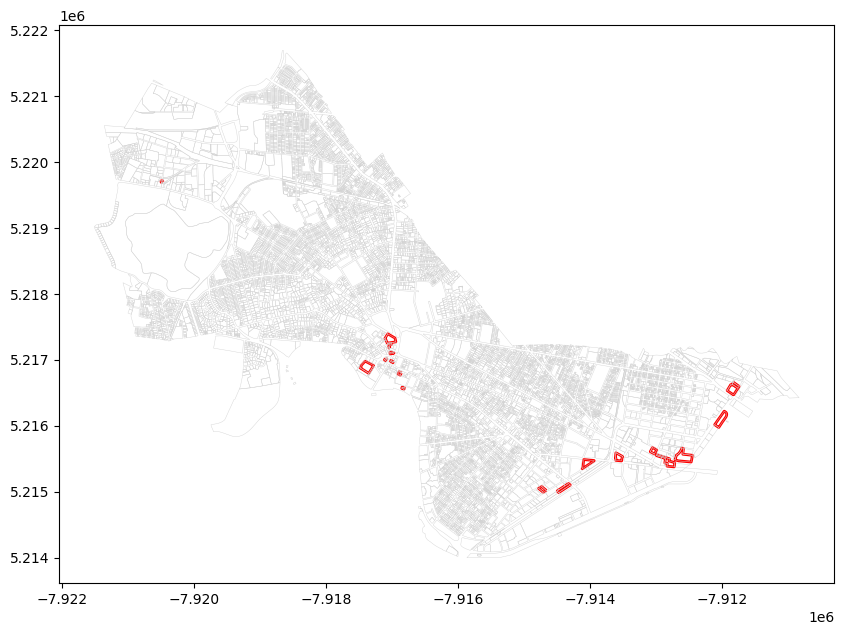

In [ ]:
!pip install contextily
import matplotlib.pyplot as plt
import contextily as ctx  # pip install contextily

# Assume `top20` is your GeoDataFrame of chosen parcels in a metric CRS
top20_proj = top20.to_crs(epsg=3857)  # Web-Mercator for basemaps

fig, ax = plt.subplots(figsize=(10, 10))
# Plot all parcels faintly (optional)
parcels.to_crs(epsg=3857).boundary.plot(ax=ax, linewidth=0.3, color='lightgray')

# Highlight top-20 parcels
top20_proj.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2)

# Add a background tile
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)

ax.set_axis_off()
plt.title("Top 20 Parcels by Land-Use Diversity", pad=12)
plt.show()

In [19]:
import geopandas as gpd

# Load data
parcels = gpd.read_file('cambridge_parcels.geojson')
census = gpd.read_file('cambridge_census_cambridge_pct.geojson')

# Define commercial use codes consistently
commercial_use_codes = [
    '300', '302', '316', '323', '324', '325', '326', '327',
    '330', '332', '334', '340', '341', '343', '345', '346',
    '353', '362', '375', '404', '406', '0340', '0406'
]

# Filter for commercial parcels
commercial_parcels = parcels[parcels['use_code'].astype(str).str.startswith(('3', '4'))]

# Ensure both datasets have same CRS
commercial_parcels = commercial_parcels.to_crs(census.crs)

# Spatial join: assign each parcel to the tract it falls within
parcels_with_census = gpd.sjoin(
    commercial_parcels,
    census,
    how='left',
    predicate='within'
)

# Drop parcels that didn't match any census tract
parcels_with_census = parcels_with_census.dropna(subset=['pct_adv_deg'])

# Sort by advanced degree percentage (higher is better)
parcels_by_education = parcels_with_census.sort_values('pct_adv_deg', ascending=False)

# Get top 20 parcels in areas with highest educational attainment
top_parcels = parcels_by_education.head(20)

# Display results
result_ids = top_parcels['ml'].tolist()
print(f"Top 20 commercial parcels in areas with highest percentage of advanced degrees:")
print(f"Parcel IDs: {result_ids}")

Top 20 commercial parcels in areas with highest percentage of advanced degrees:
Parcel IDs: ['160-14', '160-59', '133-20', '160-84', '160-85', '133-51', '160-48', '160-11', '133-54', '133-52', '160-77', '160-76', '133-15', '160-67', '160-69', '160-58', '133-14', '160-83', '133-56', '125-73']


In [ ]:
import geopandas as gpd
import pandas as pd

# Load data
parcels = gpd.read_file('cambridge_parcels.geojson')
poi = gpd.read_file('cambridge_poi_processed.geojson')
spend = pd.read_csv('cambridge_spend_processed.csv')

# Convert to projected CRS for accurate distance measurement
parcels_proj = parcels.to_crs(epsg=26986)

# Combine POI with spending data
poi_with_spend = poi.merge(
    spend,
    left_on='PLACEKEY',
    right_on='PLACEKEY',
    how='left'
)

# Fill NaN values in spending with 0
if 'RAW_TOTAL_SPEND' in poi_with_spend.columns:
    poi_with_spend['RAW_TOTAL_SPEND'] = poi_with_spend['RAW_TOTAL_SPEND'].fillna(0)
else:
    poi_with_spend['RAW_TOTAL_SPEND'] = 0

# Convert POI to projected CRS
poi_with_spend_proj = poi_with_spend.to_crs(epsg=26986)

# Calculate area spending for each parcel
def calculate_area_spending(parcel_geom, poi_geoms, spend_values, radius=200):  # 200m radius
    buffered_geom = parcel_geom.buffer(radius)
    total_spend = 0

    for i, poi_geom in enumerate(poi_geoms):
        if poi_geom is not None and buffered_geom.contains(poi_geom):
            total_spend += spend_values[i]

    return total_spend

# Calculate spending around each parcel
# For computational efficiency, evaluate at regular intervals
step = max(1, len(parcels_proj) // 1000)  # Calculate for ~1000 parcels
parcels_to_evaluate = parcels_proj.iloc[::step].copy()

poi_geoms = poi_with_spend_proj['geometry'].tolist()
spend_values = poi_with_spend_proj['RAW_TOTAL_SPEND'].tolist()

parcels_to_evaluate['area_spending'] = parcels_to_evaluate.geometry.apply(
    lambda geom: calculate_area_spending(geom, poi_geoms, spend_values)
)

# Sort by area spending (higher is better)
result_parcels = parcels_to_evaluate.sort_values('area_spending', ascending=False)
top_spending_parcels = result_parcels.head(20)

# Convert back to original CRS
top_spending_parcels = top_spending_parcels.to_crs(parcels.crs)

# Display results
result_ids = top_spending_parcels['ml'].tolist()
print(f"Top 20 parcels with highest surrounding consumer spending:")
print(f"Parcel IDs: {result_ids}")

Top 20 parcels with highest surrounding consumer spending:
Parcel IDs: ['160-66', '160-67', '169-50', '106-124', '100-40', '100-15', '100-22', '100-4', '93-55', '169-81', '106-105', '99-39', '106-109', '169-7', '169-5', '91-32', '178-118', '178-79', '178-80', '179-59']


In [20]:
import geopandas as gpd
from shapely.geometry import Point

# Load data
parcels = gpd.read_file('cambridge_parcels.geojson')

# Define subway station locations
subway_stations = [
    Point(-71.1189, 42.3736),  # Harvard Square
    Point(-71.1031, 42.3656),  # Central Square
    Point(-71.0865, 42.3625),  # Kendall/MIT
    Point(-71.1226, 42.3782),  # Porter Square
    Point(-71.1429, 42.3954)   # Alewife
]
subway_gdf = gpd.GeoDataFrame(geometry=subway_stations, crs=parcels.crs)

# Project to metric CRS for accurate buffering
parcels_proj = parcels.to_crs(epsg=26986)
subway_gdf_proj = subway_gdf.to_crs(epsg=26986)

# Define commercial use codes from the provided land use table
commercial_use_codes = [
    '300', '302', '316', '323', '324', '325', '326', '327',
    '330', '332', '334', '340', '341', '343', '345', '346',
    '353', '362', '375', '404', '406', '0340', '0406'
]

# Define vacant commercial land use codes from the provided table
vacant_commercial_codes = ['390', '391', '392', '3922']

# Filter for commercial parcels
commercial_parcels = parcels_proj[parcels_proj['use_code'].astype(str).isin(commercial_use_codes)].copy()

# Filter for vacant commercial parcels
vacant_commercial = parcels_proj[parcels_proj['use_code'].astype(str).isin(vacant_commercial_codes)].copy()

# Filter for parcels larger than 3000 sq ft
large_vacant_commercial = vacant_commercial[vacant_commercial['land_area'] > 3000].copy()

# Create 800m buffer around subway stations
subway_buffers = [geom.buffer(800) for geom in subway_gdf_proj.geometry]
union_buffer = gpd.GeoSeries(subway_buffers).unary_union

# Find large vacant commercial parcels within 800m of subway stations
result_parcels = large_vacant_commercial[large_vacant_commercial.geometry.intersects(union_buffer)].copy()

# Convert back to original CRS
result_parcels = result_parcels.to_crs(parcels.crs)

# Output results
result_ids = result_parcels['ml'].tolist()
print(f"Found {len(result_parcels)} vacant commercial parcels > 3000 sq ft within 800m of subway stations")
print(f"Parcel IDs: {result_ids}")

Found 17 vacant commercial parcels > 3000 sq ft within 800m of subway stations
Parcel IDs: ['173-35', '267E-17', '70-10', '267E-290', '189-103', '11-46', '267.2-261', '28-43', '119-21', '14-54', '267E-291', '14-55', '267.1-282', '41-28', '267F-393', '95-1', '267E-292']


<ipython-input-20-ecea5eafcb9d>:42: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  union_buffer = gpd.GeoSeries(subway_buffers).unary_union


In [30]:
import geopandas as gpd

# Load data
parcels = gpd.read_file('cambridge_parcels.geojson')
poi = gpd.read_file('cambridge_poi_processed.geojson')

# Define retail use codes
retail_use_codes = ['323', '324', '325', '326', '327', '330']

# Project to metric CRS for accurate buffering
parcels_proj = parcels.to_crs(epsg=26986)
poi_proj = poi.to_crs(epsg=26986)

# Filter for retail parcels
retail_parcels = parcels_proj[parcels_proj['use_code'].astype(str).isin(retail_use_codes)].copy()

# Filter retail businesses from POI data
retail_business_types = ['restaurant', 'clothing_store', 'department_store', 'grocery_store',
                         'convenience_store', 'furniture_store', 'hardware_store', 'electronics_store']
retail_businesses = poi_proj[poi_proj['business_type'].isin(retail_business_types)].copy()

# Function to count nearby retail businesses
def count_nearby_retail(parcel_geom, retail_geoms, buffer_distance=300):
    buffered_geom = parcel_geom.buffer(buffer_distance)
    count = sum(1 for geom in retail_geoms if geom is not None and buffered_geom.contains(geom))
    return count

# Get retail business geometries
retail_geoms = retail_businesses['geometry'].tolist()

# Calculate retail count for each retail parcel
retail_parcels.loc[:, 'nearby_retail'] = retail_parcels.geometry.apply(
    lambda geom: count_nearby_retail(geom, retail_geoms)
)

# Filter for parcels with fewer than 3 competing retail businesses
result_parcels = retail_parcels[retail_parcels['nearby_retail'] < 3].copy()

# Convert back to original CRS
result_parcels = result_parcels.to_crs(parcels.crs)

# Sort by parcel ID for consistency
result_parcels = result_parcels.sort_values('ml')

# Output results
result_ids = result_parcels['ml'].tolist()
print(f"Found {len(result_parcels)} retail parcels with <3 competing retail businesses within 300m")
print(f"Parcel IDs: {result_ids}")

Found 8 retail parcels with <3 competing retail businesses within 300m
Parcel IDs: ['189-4', '195-59', '228-55', '234-178', '260-76', '267D-259', '268B-15', '271-32']


In [33]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import LineString

# Load data
parcels = gpd.read_file('cambridge_parcels.geojson')
poi = gpd.read_file('cambridge_poi_processed.geojson')
spend_data = pd.read_csv('cambridge_spend_processed.csv')

# Define approximate Massachusetts Avenue location
mass_ave_points = [
    (-71.107894, 42.367672),  # Near Tanjore restaurant on Mass Ave
    (-71.10564, 42.367132),   # Near Fire Department on Mass Ave
    (-71.10144, 42.363676)    # Near The Boston Lamb Takedown on Mass Ave
]
mass_ave = LineString(mass_ave_points)

# Create GeoDataFrame for Mass Ave
mass_ave_gdf = gpd.GeoDataFrame(geometry=[mass_ave], crs=parcels.crs)

# Project to metric CRS for accurate buffering
parcels_proj = parcels.to_crs(epsg=26986)
mass_ave_proj = mass_ave_gdf.to_crs(epsg=26986)

# Define commercial use codes from the provided land use table
commercial_use_codes = [
    '300', '302', '316', '323', '324', '325', '326', '327',
    '330', '332', '334', '340', '341', '343', '345', '346',
    '353', '362', '375', '404', '406', '0340', '0406'
]

# Filter for commercial parcels
commercial_parcels = parcels_proj[parcels_proj['use_code'].astype(str).isin(commercial_use_codes)].copy()

# Create 1km buffer around Mass Ave
mass_ave_buffer = mass_ave_proj.buffer(1000).iloc[0]

# Find commercial parcels within 1km of Mass Ave
parcels_near_mass_ave = commercial_parcels[commercial_parcels.geometry.intersects(mass_ave_buffer)].copy()

# Combine POI with spending data
poi_with_spend = poi.merge(
    spend_data,
    left_on='PLACEKEY',
    right_on='PLACEKEY',
    how='left'
)

# Fill NaN values in spending with 0
if 'RAW_TOTAL_SPEND' in poi_with_spend.columns:
    poi_with_spend['RAW_TOTAL_SPEND'] = poi_with_spend['RAW_TOTAL_SPEND'].fillna(0)
else:
    poi_with_spend['RAW_TOTAL_SPEND'] = 0

# Project POI data to the same CRS
poi_with_spend_proj = poi_with_spend.to_crs(epsg=26986)

# Function to calculate area spending
def calculate_area_spending(parcel_geom, poi_geoms, spend_values, radius=200):  # 200m radius
    buffered_geom = parcel_geom.buffer(radius)
    total_spend = 0

    for i, poi_geom in enumerate(poi_geoms):
        if poi_geom is not None and buffered_geom.contains(poi_geom):
            total_spend += spend_values[i]

    return total_spend

# Get POI geometries and spend values
poi_geoms = poi_with_spend_proj['geometry'].tolist()
spend_values = poi_with_spend_proj['RAW_TOTAL_SPEND'].tolist()

# Calculate spending for each parcel near Mass Ave
parcels_near_mass_ave.loc[:, 'area_spending'] = parcels_near_mass_ave.geometry.apply(
    lambda geom: calculate_area_spending(geom, poi_geoms, spend_values)
)

# Sort by area spending (higher is better)
result_parcels = parcels_near_mass_ave.sort_values('area_spending', ascending=False)
top_spending_parcels = result_parcels.head(20)

# Convert back to original CRS
top_spending_parcels = top_spending_parcels.to_crs(parcels.crs)

# Output results
result_ids = top_spending_parcels['ml'].tolist()
print(f"Found {len(result_parcels)} commercial parcels within 1km of Mass Ave")
print(f"Parcel IDs: {result_ids}")


Found 234 commercial parcels within 1km of Mass Ave
Parcel IDs: ['128-71', '106-124', '90-125', '90-185', '90-133', '90-155', '91-118', '93-74', '93-76', '93-75', '93-73', '93-72', '93-79', '93-80', '93-78', '93-99', '91-208', '106-123', '90-70', '90-169']


In [34]:
import geopandas as gpd
import pandas as pd

# Load data
parcels = gpd.read_file('cambridge_parcels.geojson')
census = gpd.read_file('cambridge_census_cambridge_pct.geojson')

# Filter for commercial parcels
commercial_use_codes = [
    '300', '302', '316', '323', '324', '325', '326', '327',
    '330', '332', '334', '340', '341', '343', '345', '346',
    '353', '362', '375', '404', '406', '0340', '0406'
]

# Filter for commercial parcels
commercial_parcels = parcels[parcels['use_code'].astype(str).isin(commercial_use_codes)].copy()


# Filter for parcels larger than 8000 sq ft
large_commercial = commercial_parcels[commercial_parcels['land_area'] > 8000]

# Ensure both datasets have same CRS
large_commercial = large_commercial.to_crs(census.crs)

# Spatial join to connect parcels with census tracts (use 'predicate' instead of 'op')
parcels_with_census = gpd.sjoin(
    large_commercial,
    census,
    how='left',
    predicate='within'
)

# Filter for census tracts with at least 90% in 18-64 age bracket
result_parcels = parcels_with_census[parcels_with_census['pct_18_64'] >= 0.9]

# Sort by percentage of 18-64 year olds (higher is better)
result_parcels = result_parcels.sort_values('pct_18_64', ascending=False)

# Display results
result_ids = result_parcels['ml'].tolist()
print(f"Found {len(result_parcels)} commercial parcels >8000 sq ft in areas with ≥90% aged 18-64")
print(f"Parcel IDs: {result_ids}")

Found 33 commercial parcels >8000 sq ft in areas with ≥90% aged 18-64
Parcel IDs: ['157-26', '267.2-272', '267.2-273', '267.1-278', '267.2-267', '43-76', '43-73', '43-77', '43-71', '63-132', '54-25', '63-134', '63-131', '63-128', '63-135', '44-104', '44-106', '46-12', '47-94', '48-158', '47-97', '44-105', '44-99', '44-100', '116-12', '134-59', '134-33', '1A-209', '160-14', '160-69', '160-48', '160-11', '133-51']


In [35]:
import geopandas as gpd
from shapely.geometry import Point
from shapely.ops import unary_union

# Load data
parcels = gpd.read_file('cambridge_parcels.geojson')
poi = gpd.read_file('cambridge_poi_processed.geojson')

# Define subway station locations
subway_stations = [
    Point(-71.1189, 42.3736),  # Harvard Square
    Point(-71.1031, 42.3656),  # Central Square
    Point(-71.0865, 42.3625),  # Kendall/MIT
    Point(-71.1226, 42.3782),  # Porter Square
    Point(-71.1429, 42.3954)   # Alewife
]
subway_gdf = gpd.GeoDataFrame(geometry=subway_stations, crs=parcels.crs)

# Convert to projected CRS for accurate distance measurement
parcels_proj = parcels.to_crs(epsg=26986)
subway_gdf_proj = subway_gdf.to_crs(epsg=26986)
poi_proj = poi.to_crs(epsg=26986)

# Define commercial use codes
commercial_use_codes = [
    '300', '302', '316', '323', '324', '325', '326', '327',
    '330', '332', '334', '340', '341', '343', '345', '346',
    '353', '362', '375', '404', '406', '0340', '0406'
]

# Filter for commercial parcels
commercial_parcels = parcels_proj[parcels_proj['use_code'].astype(str).isin(commercial_use_codes)].copy()

# CONSTRAINT 1: Size between 5000-10000 sq ft
size_filtered_parcels = commercial_parcels[
    (commercial_parcels['land_area'] >= 5000) &
    (commercial_parcels['land_area'] <= 10000)
]

# CONSTRAINT 2: Within 500m of subway station
# Create 500m buffer around subway stations
subway_buffers = [geom.buffer(500) for geom in subway_gdf_proj.geometry]
union_buffer = unary_union(subway_buffers)

# Filter by location, as a true copy
location_filtered_parcels = size_filtered_parcels[
    size_filtered_parcels.geometry.intersects(union_buffer)
].copy()

# CONSTRAINT 3: No more than 1 competitor within 500m
# First identify competitors (businesses of same type)
def count_competitors(parcel_geom, parcel_use_code, poi_geoms, poi_use_codes, buffer_distance=500):
    # Get business type for this parcel
    parcel_type = str(parcel_use_code)[:3]  # First 3 digits of use code

    # Get competitor business types
    competitor_types = []
    if parcel_type.startswith('32'):  # Retail
        competitor_types = ['restaurant', 'clothing_store', 'department_store', 'grocery_store',
                           'convenience_store', 'retail']
    elif parcel_type.startswith('33'):  # Food service
        competitor_types = ['restaurant', 'cafe', 'bakery', 'fast_food']
    elif parcel_type.startswith('31'):  # Office
        competitor_types = ['offices_of_physicians', 'offices_of_other_health_practitioners',
                          'offices_of_dentists', 'offices_of_real_estate_agents']
    else:
        competitor_types = ['business_type']  # Generic

    # Create buffer
    buffered_geom = parcel_geom.buffer(buffer_distance)

    # Count competitors
    count = 0
    for i, (geom, use_code) in enumerate(zip(poi_geoms, poi_use_codes)):
        if geom is not None and buffered_geom.contains(geom):
            if any(comp_type in str(use_code).lower() for comp_type in competitor_types):
                count += 1

    return count

# Get competitors for each parcel
poi_geoms = poi_proj['geometry'].tolist()
poi_use_codes = poi_proj['business_type'].tolist()

competitor_counts = []
for idx, row in location_filtered_parcels.iterrows():
    count = count_competitors(row['geometry'], row['use_code'], poi_geoms, poi_use_codes)
    competitor_counts.append(count)

location_filtered_parcels.loc[:, 'competitor_count'] = competitor_counts

# Filter for parcels with at most 1 competitor
final_parcels = location_filtered_parcels[location_filtered_parcels['competitor_count'] <= 1]

# Convert back to original CRS
final_parcels = final_parcels.to_crs(parcels.crs)

# Display results
result_ids = final_parcels['ml'].tolist()
print(f"Found {len(final_parcels)} commercial parcels meeting all criteria:")
print(f"Parcel IDs: {result_ids}")

Found 48 commercial parcels meeting all criteria:
Parcel IDs: ['160-59', '109-51', '216-7', '107-135', '168-59', '160-64', '90-18', '168-21', '91-118', '169-82', '106-117', '118-67', '93-75', '90-13', '168-48', '117-29', '160-72', '166-24', '168-20', '109-22', '160-58', '90-70', '119-93', '91-81', '162-36', '90-161', '90-20', '118-34', '134-7', '133-49', '117-56', '160-71', '168-64', '162-68', '156-60', '156-55', '105-77', '105-89', '28-31', '162-67', '87-153', '14-26', '169-50', '168-25', '91-87', '90-185', '91-70', '169-93']


In [37]:
import geopandas as gpd
from shapely.geometry import Point

# Load data
parcels = gpd.read_file('cambridge_parcels.geojson')

# Define transit stops (subway and major bus stops)
transit_stops = [
    Point(-71.1189, 42.3736),  # Harvard Square
    Point(-71.1031, 42.3656),  # Central Square
    Point(-71.0865, 42.3625),  # Kendall/MIT
    Point(-71.1226, 42.3782),  # Porter Square
    Point(-71.1429, 42.3954),  # Alewife
    Point(-71.1195, 42.3703),  # Harvard Law School
    Point(-71.1167, 42.3803),  # Cambridge Common
    Point(-71.1055, 42.3720),  # Inman Square
    Point(-71.0955, 42.3703),  # Lechmere
    Point(-71.1066, 42.3589)   # MIT Central
]
transit_gdf = gpd.GeoDataFrame(geometry=transit_stops, crs=parcels.crs)

# Project to metric CRS for accurate buffering
parcels_proj = parcels.to_crs(epsg=26986)
transit_gdf_proj = transit_gdf.to_crs(epsg=26986)

# CONSTRAINT 1: Mixed-use zoning
# Define mixed-use codes from the provided land use table
mixed_use_codes = ['0101', '0104', '0105', '0111', '0112', '0121', '013', '031', '0340', '0406', '041', '0942']

# Filter for mixed-use parcels
mixed_use_parcels = parcels_proj[parcels_proj['use_code'].astype(str).isin(mixed_use_codes)].copy()

# CONSTRAINT 2: Within 400m of public transportation
# Create 400m buffer around transit stops
transit_buffers = [geom.buffer(400) for geom in transit_gdf_proj.geometry]
transit_union_buffer = gpd.GeoSeries(transit_buffers).unary_union

# Find mixed-use parcels within buffer
transit_accessible_parcels = mixed_use_parcels[
    mixed_use_parcels.geometry.intersects(transit_union_buffer)
].copy()

# CONSTRAINT 3: At least 200m away from industrial areas
# Define industrial use codes from the provided land use table
industrial_use_codes = ['400', '401', '407', '413']

# Filter for industrial parcels
industrial_parcels = parcels_proj[parcels_proj['use_code'].astype(str).isin(industrial_use_codes)].copy()

# Create 200m buffer around industrial parcels
industrial_buffers = [geom.buffer(200) for geom in industrial_parcels.geometry]
industrial_union_buffer = gpd.GeoSeries(industrial_buffers).unary_union

# Find parcels outside the industrial buffer
final_parcels = transit_accessible_parcels[
    ~transit_accessible_parcels.geometry.intersects(industrial_union_buffer)
].copy()

# Convert back to original CRS
final_parcels = final_parcels.to_crs(parcels.crs)

# Output results
result_ids = final_parcels['ml'].tolist()
print(f"Found {len(final_parcels)} mixed-use parcels meeting all criteria:")
print(f"Parcel IDs: {result_ids}")

Found 123 mixed-use parcels meeting all criteria:
Parcel IDs: ['224-42', '78-24', '160-53', '216-4', '108-90', '80-52', '80-147', '84-22', '29-34', '173-48', '87-40', '80-2', '105-117', '165-40', '93-49', '84-20', '160-25', '85-28', '93-81', '105-16', '119-9', '160-74', '85-64', '157-39', '119-113', '82-56', '80-58', '102-47', '155-32', '80-118', '135-87', '116-98', '105-17', '133-55', '156-24', '174-32', '168-16', '160-24', '108-28', '111-53', '265D-58', '84-87', '118-32', '79-97', '93-71', '168-45', '109-40', '106-51', '133-41', '106-122', '160-70', '108-79', '85-83', '107-1', '106-105', '174-66', '173-75', '77-39', '84-23', '162-72', '40-84', '82-71', '82-79', '174-62', '108-23', '82-12', '162-74', '268B-45', '14-1038', '85-27', '82-68', '150-41', '109-23', '80-160', '168-40', '82-54', '160-46', '162-62', '87-34', '133-43', '114-37', '119-22', '14-59', '109-87', '84-36', '92-132', '79-25', '169-85', '102-17', '86-111', '108-70', '101-120', '84-48', '79-92', '85-101', '173-34', '79-7

<ipython-input-37-cdcf405d8fc1>:36: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  transit_union_buffer = gpd.GeoSeries(transit_buffers).unary_union
<ipython-input-37-cdcf405d8fc1>:52: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  industrial_union_buffer = gpd.GeoSeries(industrial_buffers).unary_union
